In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [2]:
data_path = "./data/"
data_freq = "d"
max_epochs = 200
patience = 10
learning_rate = 0.01

In [3]:
df = pd.read_csv(data_path + "simple_va_trains.csv", sep=";", parse_dates=["DATE"])
transporteurs = ['Lyria', 'OUIGO', 'TER', 'TGV', 'intercite']
end_train_date = datetime(2018, 4, 30)
nb_days_pred = 90
vacances_df = (pd.read_csv(data_path + "vacances_etalab.csv", parse_dates=["date"])
               .rename(columns={"date": "DATE"})
               .drop("nom_vacances", axis=1))

# Préparation des données

In [4]:
df = pd.merge(df, vacances_df, on="DATE", how="left")
df["NB_TRAINS"].fillna(0, inplace=True)
df.sort_values(by=["transporteur", "DATE"], inplace=True)
df = df[(df["DATE"] >= datetime(2016, 1, 1)) & (df["DATE"] < datetime(2019, 7, 1))]
df.index = df["DATE"]
df["holiday"] = df["vacances_zone_a"] | df["vacances_zone_b"] | df["vacances_zone_c"]

df_dict = {}

for transporteur in transporteurs:
    df_dict[transporteur] = df[df["transporteur"]==transporteur].copy()
    df_dict[transporteur] = df_dict[transporteur].reindex(
        pd.date_range(start=df["DATE"].min(), end=df["DATE"].max())).drop(["DATE", "transporteur"], axis=1)
    df_dict[transporteur]["NB_TRAINS"] = df_dict[transporteur]["NB_TRAINS"].fillna(0)
df_dict["TGV"].head(3)

,VA,NB_TRAINS,vacances_zone_a,vacances_zone_b,vacances_zone_c,holiday
2016-01-01,266.684036,633,True,True,True,True
2016-01-02,357.003685,700,True,True,True,True
2016-01-03,468.776475,802,True,True,True,True


# Visualisation des séries temporelles

/Users/vincentvillet/anaconda3/envs/gluonts/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


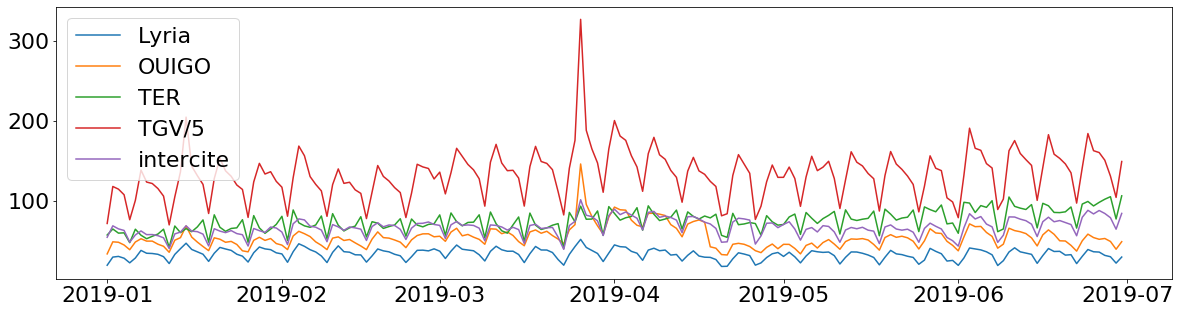

In [5]:
matplotlib.rcParams.update({'font.size': 22})

plt.figure(1, figsize=(20, 5))
for transporteur in ['Lyria', 'OUIGO', 'TER', "TGV", 'intercite']:
    transporteur_label = transporteur
    df_trans = df_dict[transporteur].copy()
    df_trans = df_trans[df_trans.index >= datetime(2019, 1, 1)]
    if transporteur == "TGV":
        df_trans["VA"] = df_trans["VA"] / 5
        transporteur_label = transporteur + "/5"
    plt.plot(df_trans.index, df_trans["VA"], label=transporteur_label)
    plt.legend()
plt.show()

# Fonctions pour entraînement de DeepAR

In [6]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

def train_predictor(df_dict, end_train_date, transporteurs_list, feat_dynamic_cols=None):
    estimator = DeepAREstimator(freq=data_freq, 
                                prediction_length=nb_days_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate = learning_rate,
                                                learning_rate_decay_factor=0.01, patience=patience),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    if feat_dynamic_cols is not None:
        
        training_data = ListDataset(
            [{"item_id": transporteur,
                "start": df_dict[transporteur].index[0],
              "target": df_dict[transporteur].VA[:end_train_date],
             "feat_dynamic_real": [df_dict[transporteur][feat_dynamic_col][:end_train_date]
                                   for feat_dynamic_col in feat_dynamic_cols] 
             }
            for transporteur in transporteurs],
            freq = data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": transporteur,
                "start": df_dict[transporteur].index[0],
              "target": df_dict[transporteur].VA[:end_train_date]
             }
            for transporteur in transporteurs],
            freq = data_freq
        )

    predictor = estimator.train(training_data=training_data)
    
    return predictor


def make_predictions(predictor, df_dict, test_date, transporteurs_list, feat_dynamic_cols=None):
    if feat_dynamic_cols is not None:
        test_data = ListDataset(
            [{"item_id": transporteur,
                "start": df_dict[transporteur].index[0],
              "target": df_dict[transporteur].VA[:test_date + timedelta(days=90)],
             "feat_dynamic_real": [df_dict[transporteur][feat_dynamic_col][:test_date + timedelta(days=90)]
                                   for feat_dynamic_col in feat_dynamic_cols]
             }
            for transporteur in transporteurs_list],
            freq = data_freq
            )
    else:
         test_data = ListDataset(
            [{"item_id": transporteur,
                "start": df_dict[transporteur].index[0],
              "target": df_dict[transporteur].VA[:test_date + timedelta(days=90)],
             }
            for transporteur in transporteurs_list],
            freq = data_freq
            )

    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
    
    return list(forecast_it), list(ts_it)


def plot_forecasts(df_dict, test_date, tss, forecasts, past_length, num_plots):
    for target, forecast in zip(tss, forecasts):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        results_mean = forecast.mean
        ground_truth = df_dict[forecast.item_id].VA[test_date + timedelta(days=1):test_date + timedelta(days=90)].values
        #import pdb; pdb.set_trace()
        gt_non_nan = np.extract(~pd.isnull(ground_truth), ground_truth)
        results_non_nan = np.extract(~pd.isnull(ground_truth), results_mean)
        MAE = np.mean(np.apply_along_axis(abs, 0, (gt_non_nan - results_non_nan) / gt_non_nan))
        plt.title(forecast.item_id + " MAE:{}%".format(str(round(100*MAE, 1))))
        plt.show()

INFO:root:Using CPU


# Test

In [7]:
transporteurs_list = ["TGV"]

tgv_predictor = train_predictor(df_dict, end_train_date, transporteurs_list, feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  7.25it/s, avg_epoch_loss=3.87]
INFO:root:Epoch[0] Elapsed time 6.898 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.868760
INFO:root:Epoch[1] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  7.64it/s, avg_epoch_loss=3.3]
INFO:root:Epoch[1] Elapsed time 6.548 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.297477
INFO:root:Epoch[2] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  7.75it/s, avg_epoch_loss=3.1]
INFO:root:Epoch[2] Elapsed time 6.453 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.102783
INFO:root:Epoch[3] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  7.84it/s, avg_epoch_loss=2.94]
INFO:root:Epoch[3] Elapsed time 6.380 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=2.943284
INFO:root:Epoch[4] Learning 

INFO:root:Epoch[75] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.10it/s, avg_epoch_loss=1.79]
INFO:root:Epoch[75] Elapsed time 6.176 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.792819
INFO:root:Epoch[76] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.11it/s, avg_epoch_loss=1.65]
INFO:root:Epoch[76] Elapsed time 6.168 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=1.652207
INFO:root:Epoch[77] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.07it/s, avg_epoch_loss=1.72]
INFO:root:Epoch[77] Elapsed time 6.194 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.716366
INFO:root:Epoch[78] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.14it/s, avg_epoch_loss=1.67]
INFO:root:Epoch[78] Elapsed time 6.143 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=1.674159
INFO:root:Epoch[79] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.10it/s, avg_epoch_loss=1.7]
INFO:root:Epoch[79

INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.14it/s, avg_epoch_loss=1.47]
INFO:root:Epoch[112] Elapsed time 6.144 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=1.466324
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.11it/s, avg_epoch_loss=1.53]
INFO:root:Epoch[113] Elapsed time 6.165 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=1.531246
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.10it/s, avg_epoch_loss=1.44]
INFO:root:Epoch[114] Elapsed time 6.174 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=1.436402
INFO:root:Epoch[115] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.12it/s, avg_epoch_loss=1.52]
INFO:root:Epoch[115] Elapsed time 6.158 seconds
INFO:root:Epoch[115] Evaluation metric 'epoch_loss'=1.520385
INFO:root:Epoch[116] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.14it/s, avg_epoch_loss=1.49]

INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.11it/s, avg_epoch_loss=1.48]
INFO:root:Epoch[149] Elapsed time 6.167 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=1.476803
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.13it/s, avg_epoch_loss=1.45]
INFO:root:Epoch[150] Elapsed time 6.154 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=1.449024
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.11it/s, avg_epoch_loss=1.41]
INFO:root:Epoch[151] Elapsed time 6.169 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=1.411591
INFO:root:Epoch[152] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.14it/s, avg_epoch_loss=1.43]
INFO:root:Epoch[152] Elapsed time 6.148 seconds
INFO:root:Epoch[152] Evaluation metric 'epoch_loss'=1.432018
INFO:root:Epoch[153] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.11it/s, avg_epoch_loss=1.44]

INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.13it/s, avg_epoch_loss=1.43]
INFO:root:Epoch[186] Elapsed time 6.148 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=1.429900
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.09it/s, avg_epoch_loss=1.4]
INFO:root:Epoch[187] Elapsed time 6.180 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=1.399737
INFO:root:Epoch[188] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=1.45]
INFO:root:Epoch[188] Elapsed time 6.186 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=1.453278
INFO:root:Epoch[189] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=1.41]
INFO:root:Epoch[189] Elapsed time 6.188 seconds
INFO:root:Epoch[189] Evaluation metric 'epoch_loss'=1.412095
INFO:root:Epoch[190] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=1.48]


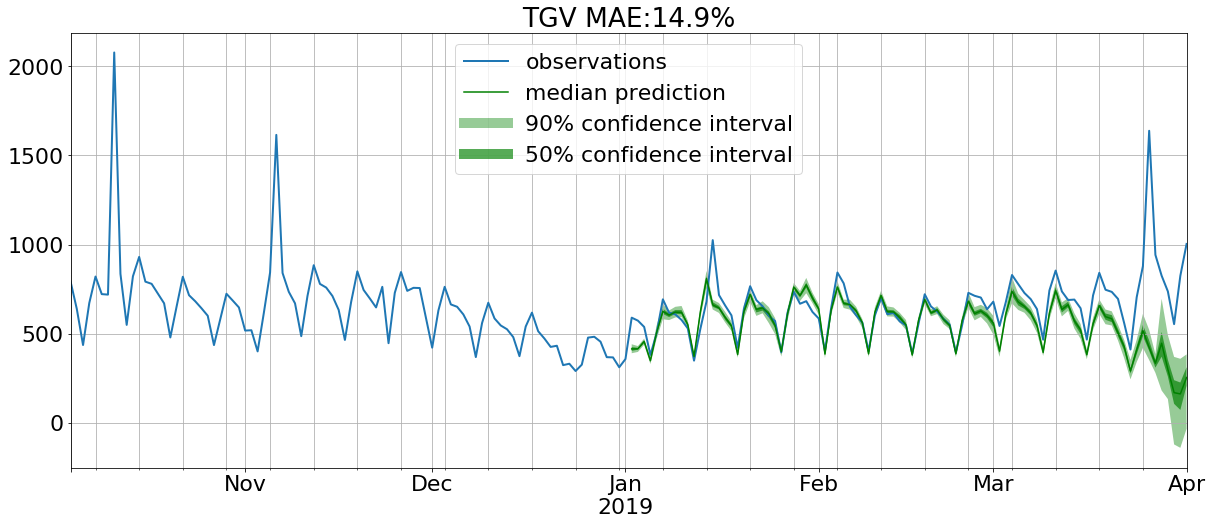

In [8]:
matplotlib.rcParams.update({'font.size': 22})
test_date = datetime(2019, 1, 1)
forecasts, tss = make_predictions(tgv_predictor, df_dict, test_date, transporteurs_list)
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_days_pred, num_plots=1)

In [9]:
all_trans_predictor = train_predictor(df_dict, end_train_date, transporteurs, feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  7.63it/s, avg_epoch_loss=4.04]
INFO:root:Epoch[0] Elapsed time 6.551 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.038595
INFO:root:Epoch[1] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.06it/s, avg_epoch_loss=3.37]
INFO:root:Epoch[1] Elapsed time 6.207 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.371086
INFO:root:Epoch[2] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.13it/s, avg_epoch_loss=3.08]
INFO:root:Epoch[2] Elapsed time 6.155 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.084899
INFO:root:Epoch[3] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=3.01]
INFO:root:Epoch[3] Elapsed time 6.187 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.008395
INFO:root:Epoch[4] Learnin

INFO:root:Epoch[75] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.13it/s, avg_epoch_loss=1.81]
INFO:root:Epoch[75] Elapsed time 6.148 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.808061
INFO:root:Epoch[76] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.11it/s, avg_epoch_loss=1.8]
INFO:root:Epoch[76] Elapsed time 6.169 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=1.798547
INFO:root:Epoch[77] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.15it/s, avg_epoch_loss=1.79]
INFO:root:Epoch[77] Elapsed time 6.137 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.787897
INFO:root:Epoch[78] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.12it/s, avg_epoch_loss=1.8]
INFO:root:Epoch[78] Elapsed time 6.158 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=1.803744
INFO:root:Epoch[79] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.12it/s, avg_epoch_loss=1.76]
INFO:root:Epoch[79]

INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=1.359206
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.10it/s, avg_epoch_loss=1.36]
INFO:root:Epoch[149] Elapsed time 6.175 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=1.359443
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.10it/s, avg_epoch_loss=1.35]
INFO:root:Epoch[150] Elapsed time 6.176 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=1.345445
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.10it/s, avg_epoch_loss=1.39]
INFO:root:Epoch[151] Elapsed time 6.175 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=1.385893
INFO:root:Epoch[152] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.14it/s, avg_epoch_loss=1.4]
INFO:root:Epoch[152] Elapsed time 6.146 seconds
INFO:root:Epoch[152] Evaluation metric 'epoch_loss'=1.404352
INFO:root:Epoch[153] Learning rate is 5e-05
100%|███

INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=1.300684
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.12it/s, avg_epoch_loss=1.35]
INFO:root:Epoch[186] Elapsed time 6.157 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=1.352111
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.11it/s, avg_epoch_loss=1.31]
INFO:root:Epoch[187] Elapsed time 6.166 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=1.313765
INFO:root:Epoch[188] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.13it/s, avg_epoch_loss=1.28]
INFO:root:Epoch[188] Elapsed time 6.148 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=1.282208
INFO:root:Epoch[189] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.07it/s, avg_epoch_loss=1.32]
INFO:root:Epoch[189] Elapsed time 6.196 seconds
INFO:root:Epoch[189] Evaluation metric 'epoch_loss'=1.316996
INFO:root:Epoch[190] Learning rate is 5e-05
100%|██

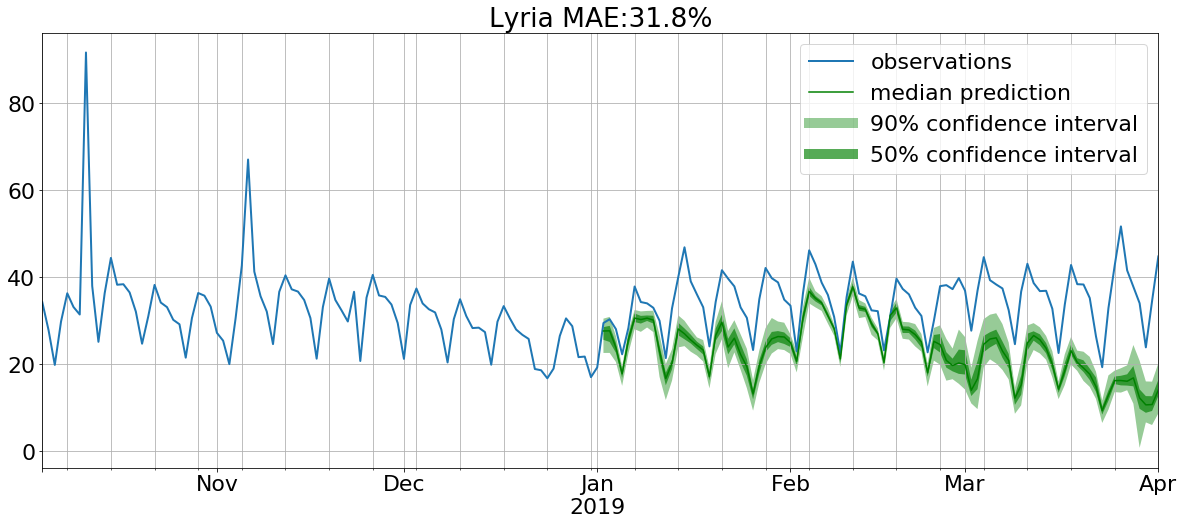

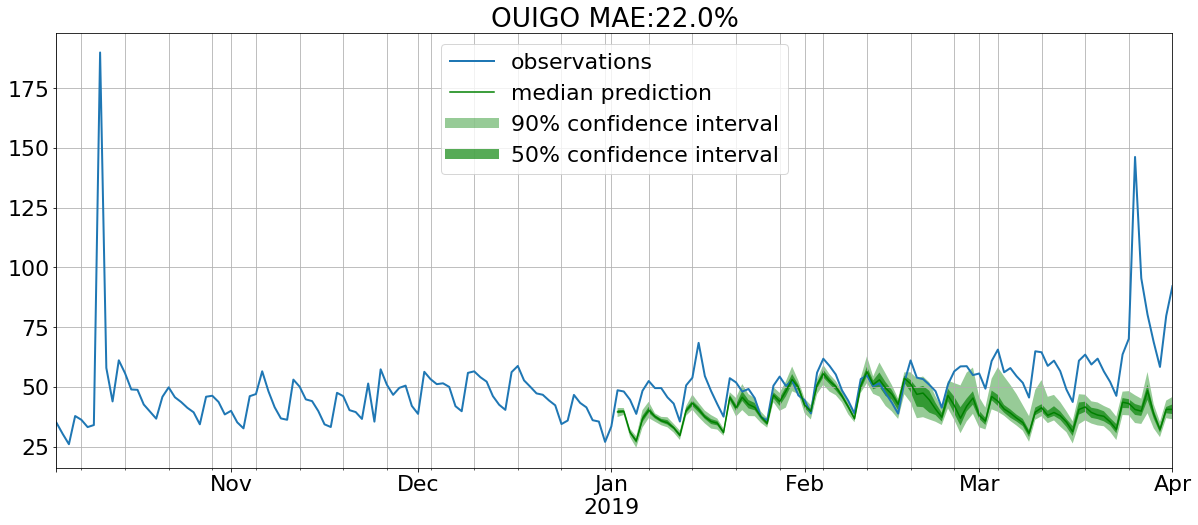

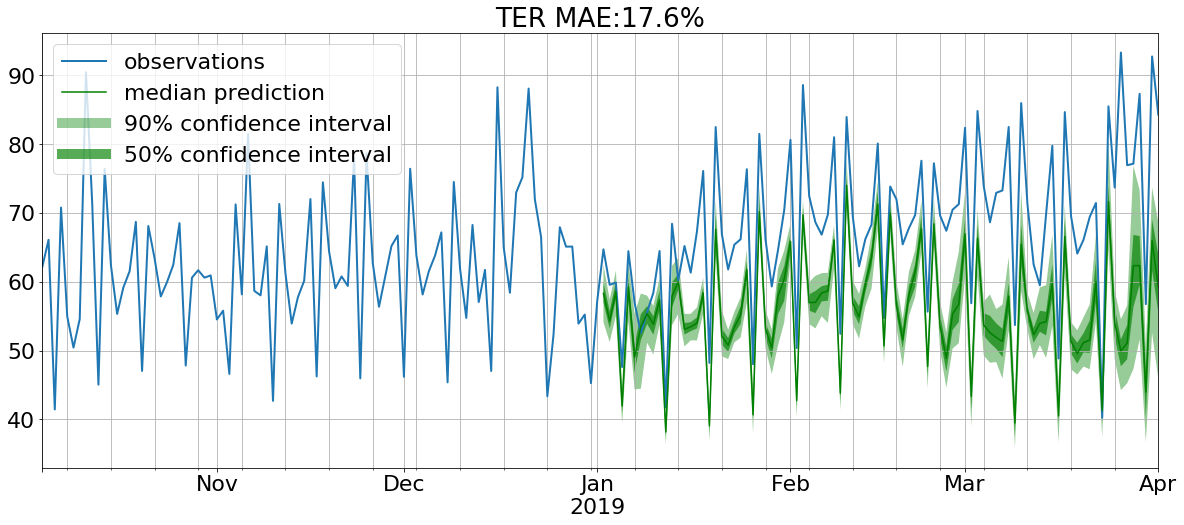

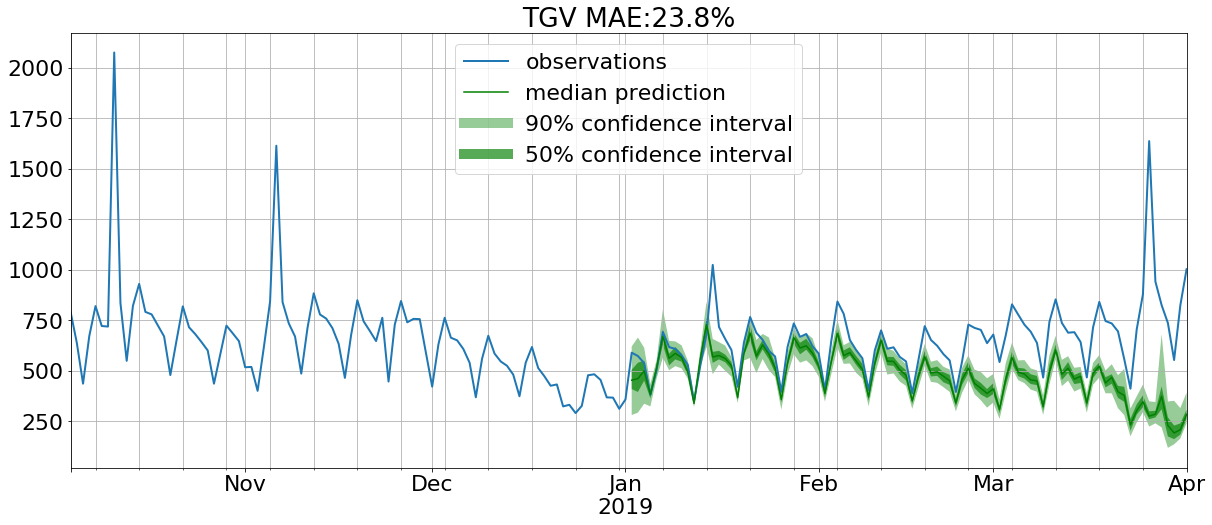

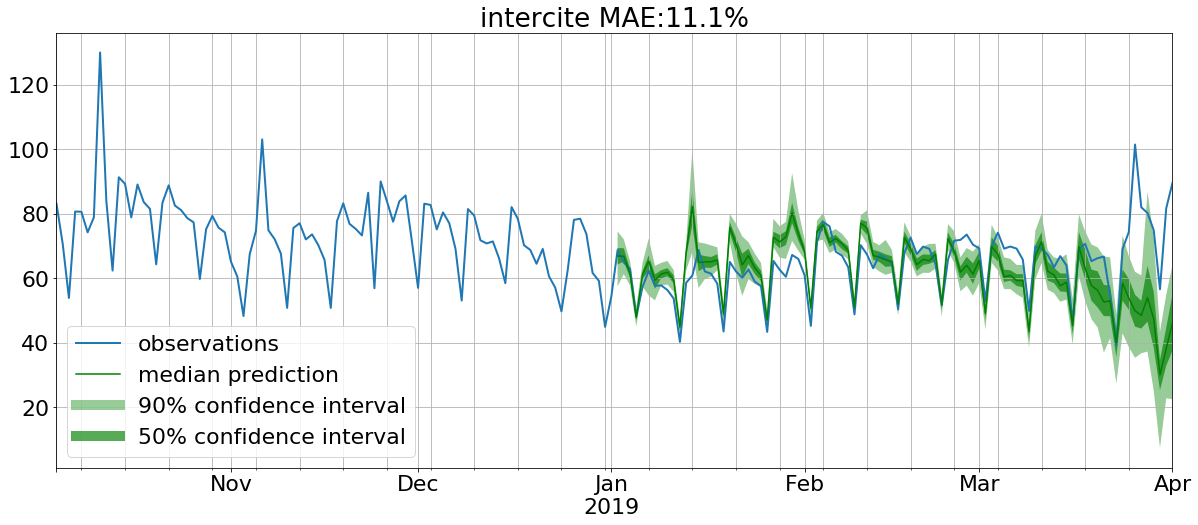

In [10]:
matplotlib.rcParams.update({'font.size': 22})
test_date = datetime(2019, 1, 1)
forecasts, tss = make_predictions(all_trans_predictor, df_dict, test_date, transporteurs)
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_days_pred, num_plots=1)

In [12]:
all_trans_predictor_vacs = train_predictor(df_dict, end_train_date, transporteurs,
                                      feat_dynamic_cols=["holiday"])

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  7.59it/s, avg_epoch_loss=4]
INFO:root:Epoch[0] Elapsed time 6.587 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.001320
INFO:root:Epoch[1] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.02it/s, avg_epoch_loss=3.28]
INFO:root:Epoch[1] Elapsed time 6.236 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.278761
INFO:root:Epoch[2] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.05it/s, avg_epoch_loss=3.1]
INFO:root:Epoch[2] Elapsed time 6.215 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.104194
INFO:root:Epoch[3] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  7.98it/s, avg_epoch_loss=3.11]
INFO:root:Epoch[3] Elapsed time 6.265 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.108048
INFO:root:Epoch[4] Learning ra

INFO:root:Epoch[75] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.07it/s, avg_epoch_loss=1.6]
INFO:root:Epoch[75] Elapsed time 6.197 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.597170
INFO:root:Epoch[76] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.05it/s, avg_epoch_loss=1.55]
INFO:root:Epoch[76] Elapsed time 6.209 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=1.554890
INFO:root:Epoch[77] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=1.59]
INFO:root:Epoch[77] Elapsed time 6.187 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.585645
INFO:root:Epoch[78] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.10it/s, avg_epoch_loss=1.59]
INFO:root:Epoch[78] Elapsed time 6.177 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=1.591547
INFO:root:Epoch[79] Learning rate is 0.01
100%|██████████| 50/50 [00:06<00:00,  8.09it/s, avg_epoch_loss=1.52]
INFO:root:Epoch[79

INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=1.29]
INFO:root:Epoch[112] Elapsed time 6.190 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=1.289659
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.06it/s, avg_epoch_loss=1.38]
INFO:root:Epoch[113] Elapsed time 6.206 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=1.378068
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=1.27]
INFO:root:Epoch[114] Elapsed time 6.193 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=1.268807
INFO:root:Epoch[115] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  7.96it/s, avg_epoch_loss=1.3]
INFO:root:Epoch[115] Elapsed time 6.279 seconds
INFO:root:Epoch[115] Evaluation metric 'epoch_loss'=1.295858
INFO:root:Epoch[116] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=1.29]


INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.04it/s, avg_epoch_loss=1.2]
INFO:root:Epoch[149] Elapsed time 6.224 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=1.197845
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.03it/s, avg_epoch_loss=1.24]
INFO:root:Epoch[150] Elapsed time 6.228 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=1.235952
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.07it/s, avg_epoch_loss=1.3]
INFO:root:Epoch[151] Elapsed time 6.194 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=1.299272
INFO:root:Epoch[152] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.05it/s, avg_epoch_loss=1.29]
INFO:root:Epoch[152] Elapsed time 6.212 seconds
INFO:root:Epoch[152] Evaluation metric 'epoch_loss'=1.285045
INFO:root:Epoch[153] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.07it/s, avg_epoch_loss=1.24]
I

INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.08it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[186] Elapsed time 6.193 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=1.159099
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  7.99it/s, avg_epoch_loss=1.2]
INFO:root:Epoch[187] Elapsed time 6.259 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=1.204965
INFO:root:Epoch[188] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.03it/s, avg_epoch_loss=1.19]
INFO:root:Epoch[188] Elapsed time 6.231 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=1.192884
INFO:root:Epoch[189] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  8.01it/s, avg_epoch_loss=1.2]
INFO:root:Epoch[189] Elapsed time 6.243 seconds
INFO:root:Epoch[189] Evaluation metric 'epoch_loss'=1.204878
INFO:root:Epoch[190] Learning rate is 5e-05
100%|██████████| 50/50 [00:06<00:00,  7.98it/s, avg_epoch_loss=1.3]
IN

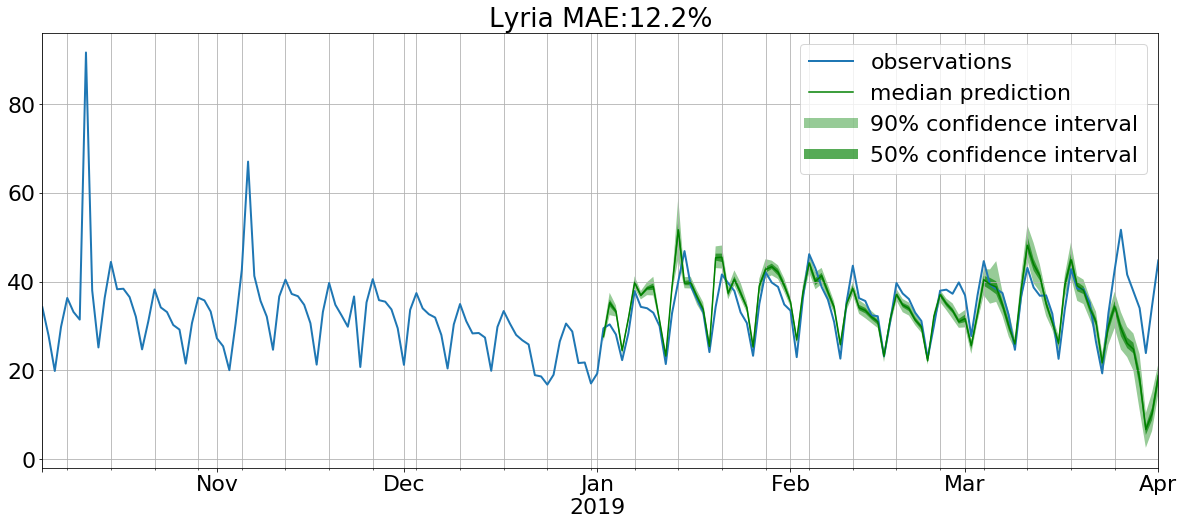

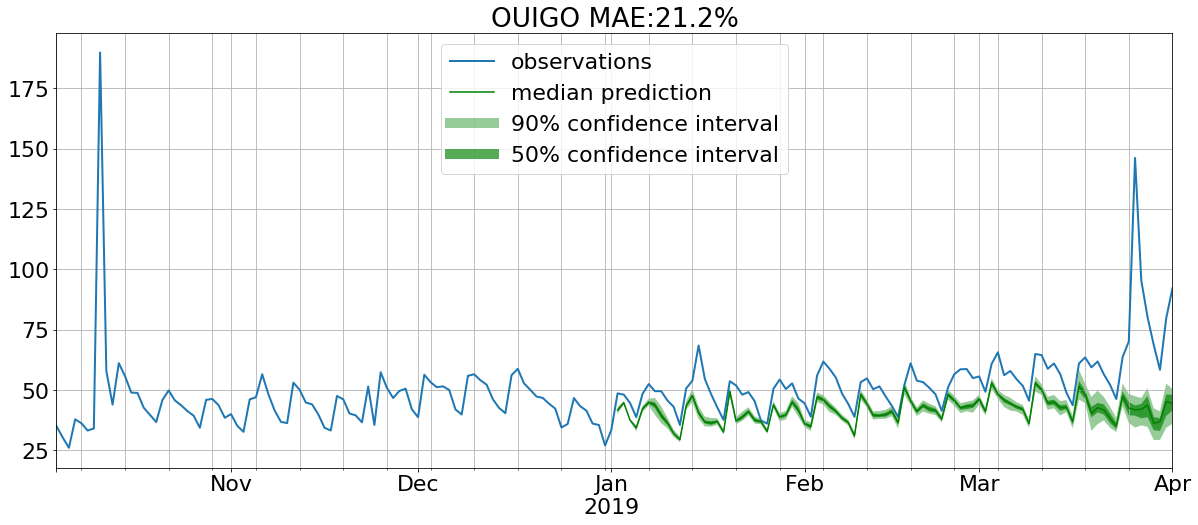

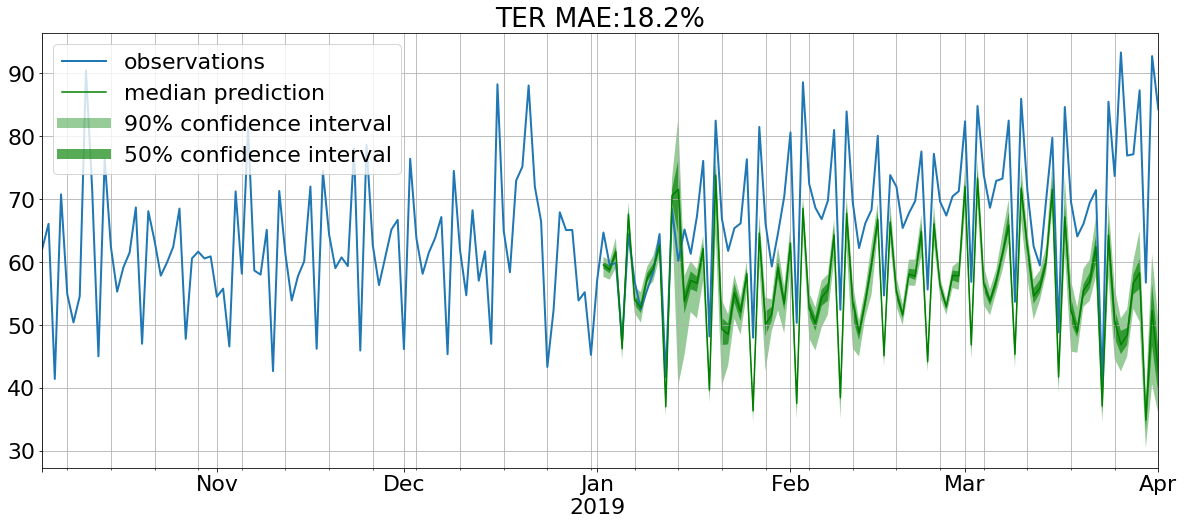

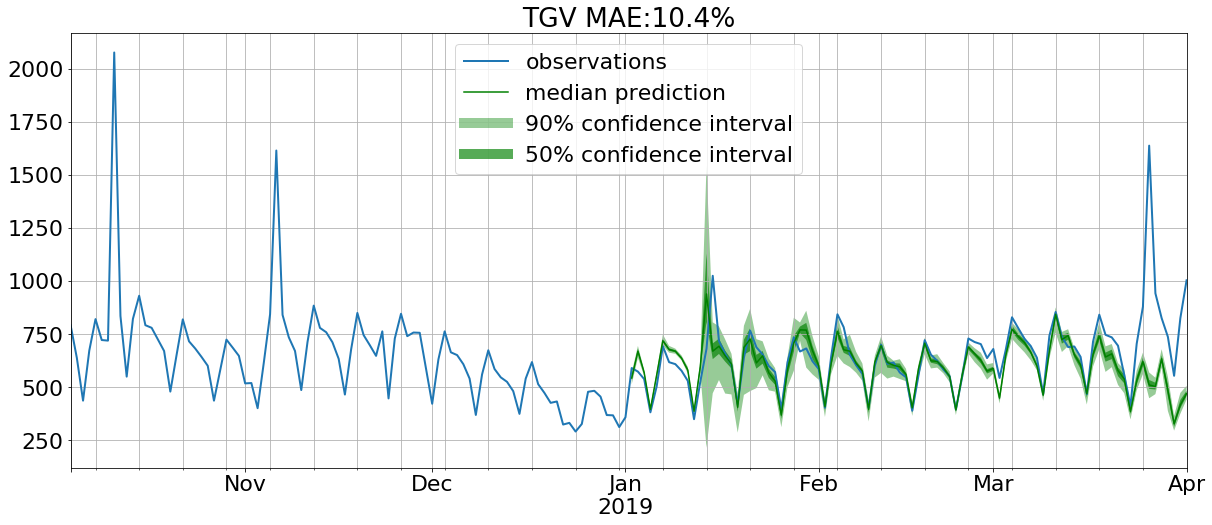

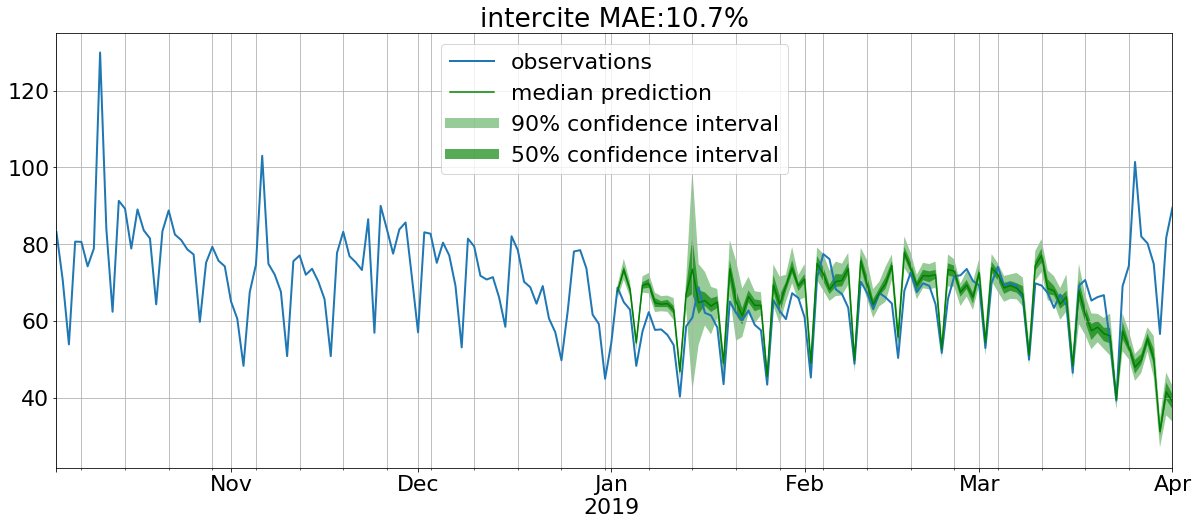

In [13]:
matplotlib.rcParams.update({'font.size': 22})
test_date = datetime(2019, 1, 1)
forecasts, tss = make_predictions(all_trans_predictor_vacs, df_dict, test_date, transporteurs,
                                 ["holiday"])
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_days_pred, num_plots=1)

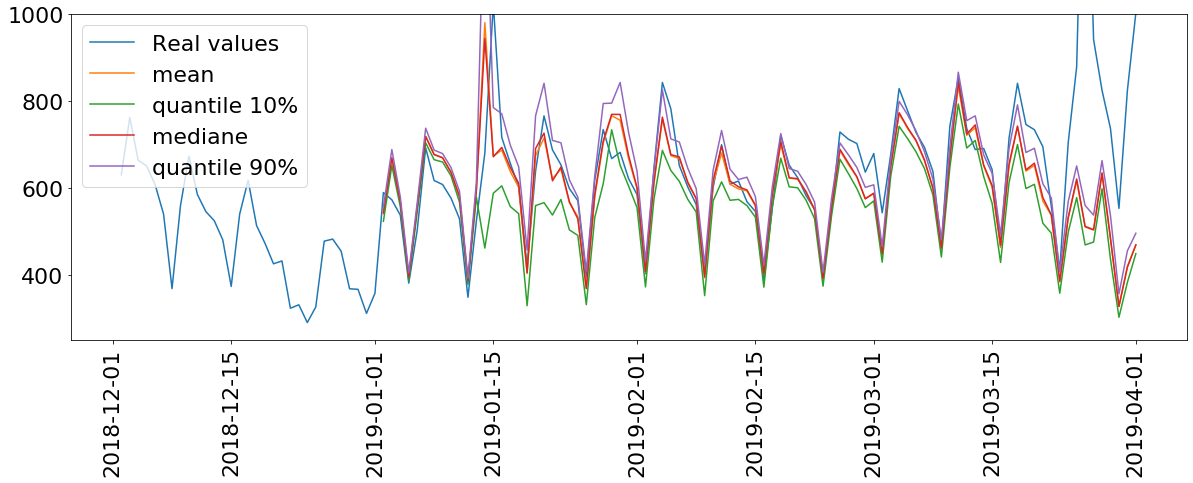

In [17]:
# Exploitation des distributions de probabilités
forecast_tgv=None
for forecast in forecasts:
    if forecast.item_id=="TGV":
        forecast_tgv = forecast

results_mean = forecast_tgv.mean
results_30 = forecast_tgv.quantile(0.1)
results_median = forecast_tgv.quantile(0.5)
results_70 = forecast_tgv.quantile(0.9)

plt.figure(1, figsize=(20, 6))
df = df_dict["TGV"]

plt.plot(pd.date_range(start=test_date - timedelta(days=30), end=test_date + timedelta(days=90)),
         df.VA[test_date - timedelta(days=30):test_date + timedelta(days=90)],
         label="Real values")

for results, results_label in zip([results_mean, results_30, results_median, results_70],
                                 ["mean", "quantile 10%", "mediane", "quantile 90%"]):
    plt.plot(pd.date_range(start=test_date + timedelta(days=1), end=test_date + timedelta(days=90)), results,
             label=results_label)
plt.ylim(250, 1000)
plt.legend()
plt.xticks(rotation="vertical")
plt.show()